In [1]:
"""Utilities for dealing with streams of numpy (record) arrays
maybe this should become its own package?
"""
import numpy as np
from strax.utils import first_index_not_below

__all__ = 'ChunkPacer fixed_size_chunks equal_chunks'.split()


class ChunkPacer:

    def __init__(self, source):
        self.source = source
        self.buffer = []
        self.buffer_items = 0

    def _fetch_another(self):
        x = next(self.source)
        self.buffer.append(x)
        self.buffer_items += len(x)

    def _squash_buffer(self):
        if len(self.buffer) > 1:
            # Since concatenate requires a memory copy,
            # we don't do it on every next call
            self.buffer = [np.concatenate(self.buffer)]

    def _take_from_buffer(self, n):
        self._squash_buffer()
        b = self.buffer[0]
        if len(b) == 0:
            raise StopIteration

        n = min(n, len(b))
        result, b = np.split(b, [n])
        self.buffer = [b]
        self.buffer_items = len(b)
        return result

    def get_n(self, n: int):
        """Return array of the next n elements produced by source,
        or (if this is less) as many as the source can still produce.

        Raises StopIteration if source has been exhausted.
        """
        try:
            while self.buffer_items < n:
                self._fetch_another()
        except StopIteration:
            pass

        return self._take_from_buffer(n)

    def get_until(self, threshold, f=None):
        """Return remaining elements of source below or at threshold,
        assuming source gives sorted arrays.

        :param f: computation to do on array elements before comparison
        """
        if f is None:
            def f(x):
                return x

        if not len(self.buffer):
            self._fetch_another()
        assert len(self.buffer) == 1

        try:
            while not f(self.buffer[-1][-1]) > threshold:
                self._fetch_another()
        except StopIteration:
            pass

        n = first_index_not_below(f(self.buffer[-1]), threshold)
        n += sum(len(x) for x in self.buffer[:-1])
        return self._take_from_buffer(n)

    def put_back_at_start(self, x):
        self.buffer = [x] + self.buffer
        self._squash_buffer()


def fixed_length_chunks(source, n=10):
    """Yield arrays of maximum length n"""
    p = ChunkPacer(source)
    try:
        while True:
            yield p.get_n(n)
    except StopIteration:
        return


In [2]:
import streamz

@streamz.register_api
class fixed_n_chunks(streamz.Stream):

    def update(self, x, who=None):
        
        
        L = []
        for item in x:
            y = self._emit(item)
            if type(y) is list:
                L.extend(y)
            else:
                L.append(y)
        return L


conda install -c conda_forge graphviz libiconf
pip install graphviz

In [ ]:
source = streamz.Stream()

def fixed_length_chunks(state, new):
    state.add(new)
    return state, ...

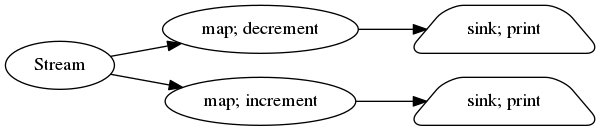

In [3]:
def increment(x):
    return x + 1

def decrement(x):
    return x - 1

source = streamz.Stream()
a = source.map(increment).sink(print)
b = source.map(decrement).sink(print)
b.visualize(rankdir='LR')

In [29]:
source = streamz.Stream()
bla = source.map(increment)
bla2 = source.map(decrement)
zipped = streamz.zip(bla, bla2)
end = zipped.sink(print)

In [30]:
source.emit(8)

(9, 7)


In [20]:
# source = streamz.Stream()

# zipped = streamz.zip(bla, bla2)
# end = zipped
# end.visualize()

In [9]:
bla2 == bla

False